In [10]:
!pip install -r requirements.txt

  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Using cached torchmetrics-0.11.1-py3-none-any.whl (517 kB)
  Using cached paddleocr-2.6.1.2-py3-none-any.whl (440 kB)
  Using cached paddlepaddle-2.4.1-cp38-cp38-manylinux1_x86_64.whl (121.6 MB)
  Using cached segmentation_models_pytorch-0.3.2-py3-none-any.whl (106 kB)
  Using cached matplotlib-3.6.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Using cached pandas-1.5.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached opencv_python-4.7.0.68-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)
ERROR: matplotlib 3.6.3 has requirement numpy>=1.19, but you'll have numpy 1.18.0 which is incompatible.
ERROR: pandas 1.5.3 has requirement numpy>=1.20.3; python_version < "3.10", but you'll have numpy 1.18.0 which is incompatible.


In [1]:
%%time
## STANDARD LIBRARY AND PIPELINE MODULES IMPORT
import warnings
warnings.filterwarnings("ignore")
from pipeline import segmentation
from pipeline import correct_perspective
from pipeline.rules import ru, find_nearby
from pipeline import OCR
from pipeline import classifier
from pipeline import vitals_detector
import os
import re
import cv2
import numpy as np
np.int=int
import matplotlib.pyplot as plt
from multiprocess import Pool
pool = Pool(processes=7)

[2023/02/07 14:49:58] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/drobot/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/drobot/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.4, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_p

YOLOv5 🚀 v7.0-72-g064365d8 Python-3.8.10 torch-1.13.1+cu117 CPU

Fusing layers... 
Model summary: 157 layers, 1768636 parameters, 0 gradients
Adding AutoShape... 


CPU times: user 7.73 s, sys: 3.43 s, total: 11.2 s
Wall time: 7.26 s


### INFERENCE FUNCTION


- We are predicting MAP as well, most of the time it will able to detect MAP

In [81]:
def vital_info(crop_info):
    return (crop_info["label"].split(" ")[0], OCR.get_text(crop_info["im"], det=False)[0][0][0], crop_info["conf"].item(), crop_info["bbox"].item(), crop_info["im"])


def inference(image_path):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    # ocr_io = cv2.resize(image, (320, 180))
    # class_io = cv2.resize(image, (640, 360))

    results = {}
    confidences = {}
    mask = segmentation.maskPred(image)
    (_, detector_io, _) =  correct_perspective.correctPerspective(image, mask)
    vitals = vitals_detector.get_vitals(detector_io)
    print(vitals.crop(save=False))
    ocr_op_info = pool.map(vital_info, vitals.crop(save=False))
    vitals.show()
    # print(ocr_op_info)
    for i in ocr_op_info:
        v, t, conf = i[0], i[1], i[2]
        t = str(t)
        t = t.replace("(", "")
        t = t.replace(")", "")
        t = t.replace("/", "")
        if v!="HR_W":
            if v in results:
                if confidences[v]<conf:
                    results[v] = t
                    confidences[v]=conf
            else:
                results[v] = t
                confidences[v]=conf
        else:
            if v in confidences:
                if confidences[v]<conf:
                    cv2.imwrite("results/HR_graph.jpg", i[3])
                    confidences[v]=conf
            else:
                cv2.imwrite("results/HR_graph.jpg", i[3])
                confidences[v]=conf

    return results

[{'box': [tensor(461.64023), tensor(91.74049), tensor(508.74307), tensor(143.17824)], 'conf': tensor(0.41040), 'cls': tensor(3.), 'label': 'SPO2 0.41', 'im': array([[[102,  74,  67],
        [101,  75,  66],
        [103,  78,  69],
        ...,
        [100,  78,  66],
        [102,  80,  68],
        [101,  79,  67]],

       [[103,  77,  70],
        [103,  77,  70],
        [103,  77,  70],
        ...,
        [ 98,  76,  64],
        [102,  80,  69],
        [101,  79,  67]],

       [[102,  76,  69],
        [102,  76,  69],
        [103,  77,  70],
        ...,
        [107,  85,  73],
        [104,  85,  72],
        [103,  84,  71]],

       ...,

       [[106,  76,  70],
        [109,  80,  75],
        [105,  78,  72],
        ...,
        [102,  80,  73],
        [103,  80,  73],
        [104,  79,  71]],

       [[105,  75,  70],
        [107,  78,  73],
        [104,  76,  70],
        ...,
        [104,  81,  73],
        [105,  82,  74],
        [104,  80,  72]],

    

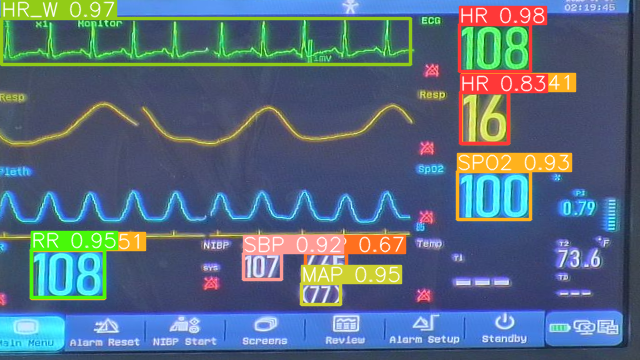

Vitals -  {'SPO2': '100', 'DBP': '65', 'HR': '108', 'SBP': '107', 'RR': '108', 'MAP': '77'}
CPU times: user 3.43 s, sys: 71.6 ms, total: 3.51 s
Wall time: 778 ms


In [82]:
%%time
## EVALUATION ON EACH IMAGE
img_classes = [ 'BPL-EliteView-EV10-B_Meditec-England-A', 'BPL-EliteView-EV100-C' , 'BPL-Ultima-PrimeD-A' , 'Nihon-Kohden-lifescope-A']
TEST_IMG_DIR = "test_data"

imlis = os.listdir(TEST_IMG_DIR)
imloc = f"{TEST_IMG_DIR}/{imlis[17]}"

## RUN INFERENCE FUNCTION
vitals = inference(imloc)
print("Vitals - ", vitals)

### ADDITIONAL (HR GRAPH DIGITIZATION)

In [12]:
d_im

[('DBP',
  '78',
  array([[[129,  83,  69],
          [134,  86,  72],
          [135,  87,  72],
          ...,
          [130,  82,  64],
          [129,  81,  63],
          [129,  81,  63]],
  
         [[137,  89,  76],
          [139,  90,  76],
          [136,  87,  72],
          ...,
          [127,  79,  61],
          [129,  81,  63],
          [132,  84,  66]],
  
         [[133,  84,  70],
          [130,  81,  67],
          [130,  81,  67],
          ...,
          [127,  81,  64],
          [129,  82,  65],
          [133,  86,  68]],
  
         ...,
  
         [[136,  85,  68],
          [133,  82,  65],
          [134,  83,  67],
          ...,
          [136,  81,  66],
          [137,  82,  67],
          [139,  84,  69]],
  
         [[137,  85,  71],
          [136,  83,  69],
          [138,  85,  72],
          ...,
          [134,  80,  64],
          [135,  80,  65],
          [138,  83,  68]],
  
         [[134,  81,  68],
          [132,  79,  66],
       

In [5]:
plt.imshow(d_im)

In [4]:
%%time
results = vitals_detector.get_vitals(d_im)  # inference

CPU times: user 382 ms, sys: 2.16 ms, total: 384 ms
Wall time: 51.3 ms


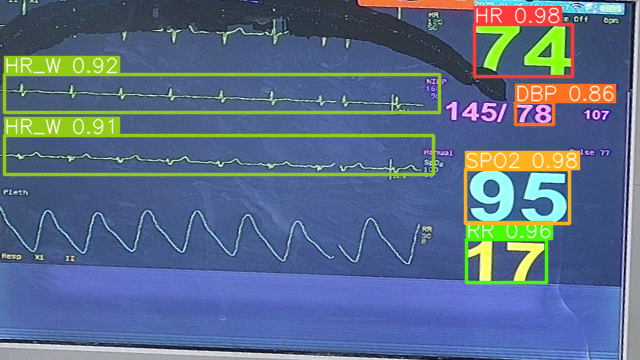

In [22]:
results.show()

In [5]:
l results.crop(save=False)

In [6]:
%%time
for indx, i in enumerate(l):
    im = i["im"]
    print(i["label"].split(" ")[0])
    print(OCR.get_text(im, det = False)[0][0][0])

DBP
[2023/02/07 14:50:17] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
78
HR_W
[2023/02/07 14:50:17] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
mammtn
HR_W
[2023/02/07 14:50:17] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process

RR
[2023/02/07 14:50:17] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
17
SPO2
[2023/02/07 14:50:17] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
95
HR
[2023/02/07 14:50:17] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
74
CPU times: user 471 ms, sys: 806 µs, total: 472 ms
Wall time:

In [8]:
len(l)

6

In [9]:
%%time


CPU times: user 38.4 ms, sys: 632 µs, total: 39.1 ms
Wall time: 254 ms


[('DBP',
  '78',
  array([[[129,  83,  69],
          [134,  86,  72],
          [135,  87,  72],
          ...,
          [130,  82,  64],
          [129,  81,  63],
          [129,  81,  63]],
  
         [[137,  89,  76],
          [139,  90,  76],
          [136,  87,  72],
          ...,
          [127,  79,  61],
          [129,  81,  63],
          [132,  84,  66]],
  
         [[133,  84,  70],
          [130,  81,  67],
          [130,  81,  67],
          ...,
          [127,  81,  64],
          [129,  82,  65],
          [133,  86,  68]],
  
         ...,
  
         [[136,  85,  68],
          [133,  82,  65],
          [134,  83,  67],
          ...,
          [136,  81,  66],
          [137,  82,  67],
          [139,  84,  69]],
  
         [[137,  85,  71],
          [136,  83,  69],
          [138,  85,  72],
          ...,
          [134,  80,  64],
          [135,  80,  65],
          [138,  83,  68]],
  
         [[134,  81,  68],
          [132,  79,  66],
       

In [20]:
imloc

'test_data/drpremhospital_ccu_mon--E_2023_1_5_7_41_0.jpeg'